# Introduction/Business Problem 

### Someone recently moved to Portugal and this person owns a franchising brand of restaurants. This person wants to know which will be the best city to fit his new restaurant.
### Besides many other variables that might induct the person to decide where to start this new business, we will try to help him to decide where to start by creating one index which will consist of the ratio between the population of the city versus the number of restaurants that this city already has.
### This index aims to give to the requester which city may be better once that will have an index with more demand and less offering restaurants.

### Formula:
### Potential Index = Population of each city divided by the number of restaurants

# Data Section

## For this capstone, we will be using two main databases:
### 1. We will be using the following spreadsheet which has been retrieved from https://simplemaps.com/data/pt-cities and consists with a list of all cities from Portugal, including the geospatial coordinates and the population.
### 2. We will also use the Foursquare API in order to get how many restaurants we have in each city

In [1]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
pip install nominatim

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

df_pt = pd.read_csv("pt.csv")
print(df_pt.head())

                city      lat     lng   country iso2 admin_name  capital  \
0             Lisbon  38.7452 -9.1604  Portugal   PT     Lisboa  primary   
1  Vila Nova de Gaia  41.1333 -8.6167  Portugal   PT      Porto    minor   
2              Porto  41.1495 -8.6108  Portugal   PT      Porto    admin   
3              Braga  41.5333 -8.4167  Portugal   PT      Braga    admin   
4         Matosinhos  41.2077 -8.6674  Portugal   PT      Porto    minor   

   population  population_proper  
0    506654.0           506654.0  
1    302295.0           302295.0  
2    237591.0           237591.0  
3    181494.0           181494.0  
4    175478.0           175478.0  


In [5]:
#joining the two data frames
#result = pd.concat([df, df_pt], axis=1, join="inner")
#result

In [6]:
address = 'Portugal, PT'

geolocator = Nominatim(user_agent="pt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portugal are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Portugal are 40.0332629, -7.8896263.


In [7]:
# create map of Portugal using latitude and longitude values
map_pt = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, city, capital in zip(df_pt['lat'], df_pt['lng'], df_pt['city'], df_pt['capital']):
    label = '{}, {}'.format(city, capital)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pt)  
    
map_pt

In [8]:
# setting connection to foursquare API
CLIENT_ID = '43P5ISSYKZRRU40CQERHE55JTJABJERILT0BMGSQSN0GNOY0' # your Foursquare ID
CLIENT_SECRET = 'BWSUBCVJKJZ0LDOAZ0K3XPRPNDBEYH0RKYCYGHKGD52CMJOB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 43P5ISSYKZRRU40CQERHE55JTJABJERILT0BMGSQSN0GNOY0
CLIENT_SECRET:BWSUBCVJKJZ0LDOAZ0K3XPRPNDBEYH0RKYCYGHKGD52CMJOB


In [9]:
df_pt.loc[0, 'city']

'Lisbon'

In [10]:
city_latitude = df_pt.loc[0, 'lat'] # neighborhood latitude value
city_longitude = df_pt.loc[0, 'lng'] # neighborhood longitude value

city_name = df_pt.loc[0, 'city'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

Latitude and longitude values of Lisbon are 38.7452, -9.1604.


In [11]:
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=43P5ISSYKZRRU40CQERHE55JTJABJERILT0BMGSQSN0GNOY0&client_secret=BWSUBCVJKJZ0LDOAZ0K3XPRPNDBEYH0RKYCYGHKGD52CMJOB&v=20180605&ll=38.7452,-9.1604&radius=500&limit=100'

In [12]:
import requests
results =  requests.get(url).json()
#results = requests.get(url)

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name             categories        lat       lng
0               Malo Clinic         Medical Center  38.746271 -9.163602
1  Mariott Executive Lounge              Hotel Bar  38.747059 -9.164141
2                   Lucimar  Portuguese Restaurant  38.743135 -9.155755
3    Escritórios NOS - Café              Cafeteria  38.744550 -9.158933
4   Restaurante Santa Maria              BBQ Joint  38.745503 -9.158635

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
pt_venues = getNearbyVenues(names=df_pt['city'],
                                   latitudes=df_pt['lat'],
                                   longitudes=df_pt['lng']
                                  )

Lisbon
Vila Nova de Gaia
Porto
Braga
Matosinhos
Amadora
Almada
Oeiras
Gondomar
Guimarães
Odivelas
Coimbra
Vila Franca de Xira
Maia
Leiria
Setúbal
Funchal
Viseu
Valongo
Viana do Castelo
Paredes
Vila do Conde
Torres Vedras
Barreiro
Aveiro
Queluz
Mafra
Penafiel
Loulé
Ponta Delgada
Moita
Faro
Póvoa de Varzim
Palmela
Santarém
Figueira da Foz
Felgueiras
Paços de Ferreira
Amarante
Castelo Branco
Évora
Portimão
Pombal
Marco de Canavezes
Vila Real
Covilhã
Caldas da Rainha
Montijo
Rio Tinto
Fafe
Sesimbra
Amora
Vila Verde
Lousada
Ourém
Olhão
Ponte de Lima
Santa Cruz
Guarda
Chaves
Tomar
Ílhavo
Trofa
Ermezinde
Marinha Grande
Silves
Torres Novas
Beja
Agualva
Câmara de Lobos
Angra do Heroísmo
Bragança
Esposende
Ribeira Grande
Espinho
Lagos
Anadia
Benavente
Massamá
Estarreja
Lamego
Estoril
Montemor-o-Velho
Tavira
Odemira
Albergaria-a-Velha
Portalegre
Porto de Mós
Mirandela
Vizela
Almeirim
Caniço
Oliveira do Bairro
Vale de Cambra
Póvoa de Lanhoso
Azambuja
São João da Madeira
Cacém
Rio Maior
Praia da Vi

In [17]:
print(pt_venues.shape)
pt_venues.head()

(2727, 7)


city  City Latitude  City Longitude                     Venue  \
0  Lisbon        38.7452         -9.1604               Malo Clinic   
1  Lisbon        38.7452         -9.1604  Mariott Executive Lounge   
2  Lisbon        38.7452         -9.1604                   Lucimar   
3  Lisbon        38.7452         -9.1604    Escritórios NOS - Café   
4  Lisbon        38.7452         -9.1604   Restaurante Santa Maria   

   Venue Latitude  Venue Longitude         Venue Category  
0       38.746271        -9.163602         Medical Center  
1       38.747059        -9.164141              Hotel Bar  
2       38.743135        -9.155755  Portuguese Restaurant  
3       38.744550        -9.158933              Cafeteria  
4       38.745503        -9.158635              BBQ Joint

In [18]:
pt_venues.groupby('city').count()

City Latitude  City Longitude  Venue  \
city                                                                
Abrantes                                 4               4      4   
Agualva                                 10              10     10   
Aguiar da Beira                          4               4      4   
Alandroal                                4               4      4   
Albergaria-a-Velha                       4               4      4   
Albufeira                               53              53     53   
Alcanena                                 5               5      5   
Alcobaça                                12              12     12   
Alcochete                               17              17     17   
Alcoutim                                 4               4      4   
Alcácer do Sal                          12              12     12   
Alenquer                                 5               5      5   
Alfena                                   6               6      6   
Alfândega da Fé                          8               8      8   
Alijó                                    4               4      4   
Aljezur                                 11              11     11   
Aljustrel                                5               5      5   
Almada                                  39              39     39   
Almargem                                 2               2      2   
Almeida                                  6               6      6   
Almeirim                                 1               1      1   
Almodôvar                                4               4      4   
Alpiarça                                 7               7      7   
Alter do Chão                            7               7      7   
Alvaiázere                               4               4      4   
Alvito                                   6               6      6   
Amadora                                  8               8      8   
Amarante                                11              11     11   
Amares                                   1               1      1   
Amora                                    5               5      5   
Anadia                                   1               1      1   
Angra do Heroísmo                       16              16     16   
Ansião                                   2               2      2   
Arcos de Valdevez                        3               3      3   
Arcozelo                                 5               5      5   
Arganil                                  5               5      5   
Argoncilhe                               1               1      1   
Armação de Pêra                         13              13     13   
Arouca                                  12              12     12   
Arraiolos                                8               8      8   
Arronches                                1               1      1   
Aveiro                                  39              39     39   
Aver-o-Mar                               5               5      5   
Azambuja                                 4               4      4   
Baião                                    4               4      4   
Barcelos                                19              19     19   
Barrancos                                5               5      5   
Barreiro                                13              13     13   
Beja                                     1               1      1   
Belmonte                                 9               9      9   
Benavente                                1               1      1   
Bombarral                                4               4      4   
Borba                                    2               2      2   
Boticas                                  6               6      6   
Braga                                    6               6      6   
Bragança                                 8               8      8   
Cabeceiras de Basto        

In [19]:
# one hot encoding
pt_onehot = pd.get_dummies(pt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pt_onehot['city'] = pt_venues['city'] 

# move neighborhood column to the first column
fixed_columns = [pt_onehot.columns[-1]] + list(pt_onehot.columns[:-1])
pt_onehot = pt_onehot[fixed_columns]

pt_onehot.head()

city  Accessories Store  Airport Terminal  American Restaurant  Aquarium  \
0  Lisbon                  0                 0                    0         0   
1  Lisbon                  0                 0                    0         0   
2  Lisbon                  0                 0                    0         0   
3  Lisbon                  0                 0                    0         0   
4  Lisbon                  0                 0                    0         0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                     0                 0                   0            0   
1                     0                 0                   0            0   
2                     0                 0                   0            0   
3                     0                 0                   0            0   
4                     0                 0                   0            0   

   Auto Workshop  BBQ Joint  Bagel Shop  Bakery  Bar  Basketball Court  \
0              0          0           0       0    0                 0   
1              0          0           0       0    0                 0   
2              0          0           0       0    0                 0   
3              0          0           0       0    0                 0   
4              0          1           0       0    0                 0   

   Basketball Stadium  Bay  Beach  Beach Bar  Bed & Breakfast  Beer Bar  \
0                   0    0      0          0                0         0   
1                   0    0      0          0                0         0   
2                   0    0      0          0                0         0   
3                   0    0      0          0                0         0   
4                   0    0      0          0                0         0   

   Beer Garden  Big Box Store  Bistro  Board Shop  Boarding House  \
0            0              0       0           0               0   
1            0              0       0           0               0   
2            0              0       0           0               0   
3            0              0       0           0               0   
4            0              0       0           0               0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Brazilian Restaurant  \
0              0          0         0              0                     0   
1              0          0         0              0                     0   
2              0          0         0              0                     0   
3              0          0         0              0                     0   
4              0          0         0              0                     0   

   Breakfast Spot  Brewery  Buffet  Burger Joint  Bus Line  Bus Station  \
0               0        0       0             0         0            0   
1               0        0       0             0         0            0   
2               0        0       0             0         0            0   
3               0        0       0             0         0            0   
4               0        0       0             0         0            0   

   Bus Stop  Cafeteria  Café  Camera Store  Campground  Canal  Canal Lock  \
0         0          0     0             0           0      0           0   
1         0          0     0             0           0      0           0   
2         0          0     0             0           0      0           0   
3         0          1     0             0           0     

In [20]:
pt_venues.shape

(2727, 7)

In [21]:
pt_grouped = pt_onehot.groupby('city').mean().reset_index()
pt_grouped

city  Accessories Store  Airport Terminal  \
0                       Abrantes                0.0          0.000000   
1                        Agualva                0.1          0.000000   
2                Aguiar da Beira                0.0          0.000000   
3                      Alandroal                0.0          0.000000   
4             Albergaria-a-Velha                0.0          0.000000   
5                      Albufeira                0.0          0.000000   
6                       Alcanena                0.0          0.000000   
7                       Alcobaça                0.0          0.000000   
8                      Alcochete                0.0          0.000000   
9                       Alcoutim                0.0          0.000000   
10                Alcácer do Sal                0.0          0.000000   
11                      Alenquer                0.0          0.000000   
12                        Alfena                0.0          0.000000   
13               Alfândega da Fé                0.0          0.000000   
14                         Alijó                0.0          0.000000   
15                       Aljezur                0.0          0.000000   
16                     Aljustrel                0.0          0.000000   
17                        Almada                0.0          0.000000   
18                      Almargem                0.0          0.000000   
19                       Almeida                0.0          0.000000   
20                      Almeirim                0.0          0.000000   
21                     Almodôvar                0.0          0.000000   
22                      Alpiarça                0.0          0.000000   
23                 Alter do Chão                0.0          0.000000   
24                    Alvaiázere                0.0          0.000000   
25                        Alvito                0.0          0.000000   
26                       Amadora                0.0          0.000000   
27                      Amarante                0.0          0.000000   
28                        Amares                0.0          0.000000   
29                         Amora                0.0          0.000000   
30                        Anadia                0.0          0.000000   
31             Angra do Heroísmo                0.0          0.000000   
32                        Ansião                0.0          0.000000   
33             Arcos de Valdevez                0.0          0.000000   
34                      Arcozelo                0.0          0.000000   
35                       Arganil                0.0          0.000000   
36                    Argoncilhe                0.0          0.000000   
37               Armação de Pêra                0.0          0.000000   
38                        Arouca                0.0          0.000000   
39                     Arraiolos                0.0          0.000000   
40                     Arronches                0.0          0.000000   
41                        Aveiro                0.0          0.000000   
42                    Aver-o-Mar                0.0          0.000000   
43                      Azambuja                0.0          0.000000   
44                         Baião                0.0          0.000000   
45                      Barcelos                0.0          0.000000   
46                     Barrancos                0.0          0.000000   
47                      Barreiro                0.0          0.000000   
48                          Beja                0.0          0.000000   
49                      Belmonte                0.0          0.000000   
50                     Benavente                0.0          0.000000   
51                     Bombarral                0.0          0.000000   
52                         Borba                0.0          0.000000   
53                       Boticas                0.0          0.000000   
54           

In [22]:
pt_grouped.shape

(286, 216)

In [23]:
num_top_venues = 5

for hood in pt_grouped['city']:
    print("----"+hood+"----")
    temp = pt_grouped[pt_grouped['city'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abrantes----
                  venue  freq
0                   Bar  0.50
1           Supermarket  0.25
2         Grocery Store  0.25
3     Accessories Store  0.00
4  Other Great Outdoors  0.00


----Agualva----
               venue  freq
0               Café   0.3
1  Accessories Store   0.1
2      Train Station   0.1
3  Electronics Store   0.1
4        Bus Station   0.1


----Aguiar da Beira----
                   venue  freq
0                   Food  0.25
1  Portuguese Restaurant  0.25
2           Soccer Field  0.25
3                    Bar  0.25
4      Accessories Store  0.00


----Alandroal----
                   venue  freq
0                  Hotel  0.25
1          Historic Site  0.25
2  Portuguese Restaurant  0.25
3             Restaurant  0.25
4      Accessories Store  0.00


----Albergaria-a-Velha----
             venue  freq
0          Theater  0.25
1           Garden  0.25
2           Market  0.25
3             Café  0.25
4  Other Nightlife  0.00


----Albufeira----
      

4            Multiplex   0.0


----Carregal do Sal----
                  venue  freq
0                   Bar  0.67
1                  Pool  0.17
2      Basketball Court  0.17
3     Accessories Store  0.00
4  Other Great Outdoors  0.00


----Cartaxo----
               venue  freq
0         Restaurant  0.50
1     Ice Cream Shop  0.17
2        Supermarket  0.17
3   Tapas Restaurant  0.17
4  Accessories Store  0.00


----Carvoeiro----
                   venue  freq
0  Portuguese Restaurant  0.22
1                 Bakery  0.11
2                    Bar  0.11
3             Restaurant  0.11
4             Steakhouse  0.11


----Cascais----
                   venue  freq
0  Portuguese Restaurant  0.13
1             Restaurant  0.07
2       Tapas Restaurant  0.06
3       Sushi Restaurant  0.06
4      Indian Restaurant  0.06


----Castelo Branco----
                   venue  freq
0  Portuguese Restaurant  0.19
1                    Bar  0.19
2                  Hotel  0.05
3                 Bakery  

                   venue  freq
0             Restaurant   0.4
1  Portuguese Restaurant   0.2
2           Neighborhood   0.2
3              BBQ Joint   0.2
4      Accessories Store   0.0


----Marco de Canavezes----
           venue  freq
0            Bar  0.16
1     Restaurant  0.12
2         Bakery  0.12
3           Café  0.08
4  Shopping Mall  0.08


----Marinha Grande----
                   venue  freq
0            Pizza Place  0.12
1  Portuguese Restaurant  0.12
2                   Café  0.12
3                    Bar  0.12
4                 Bakery  0.12


----Marvão----
                   venue  freq
0        Bed & Breakfast  0.22
1         Boarding House  0.11
2                 Lounge  0.11
3                 Museum  0.11
4  Portuguese Restaurant  0.11


----Massamá----
              venue  freq
0          Pharmacy   0.2
1              Park   0.2
2  Sushi Restaurant   0.2
3      Burger Joint   0.2
4              Café   0.2


----Matosinhos----
                  venue  freq
0       



----Sabrosa----
                   venue  freq
0                  Hotel  0.29
1  Portuguese Restaurant  0.29
2                   Pool  0.14
3     Italian Restaurant  0.14
4                   Café  0.14


----Sabugal----
                   venue  freq
0         Boarding House  0.17
1               Pharmacy  0.17
2  Portuguese Restaurant  0.17
3             Restaurant  0.17
4          Jewelry Store  0.17


----Sacavém----
                   venue  freq
0  Portuguese Restaurant   0.2
1            Coffee Shop   0.1
2            Pizza Place   0.1
3   Fast Food Restaurant   0.1
4             Restaurant   0.1


----Salvaterra de Magos----
                   venue  freq
0                 Bakery  0.14
1  Portuguese Restaurant  0.14
2          Grocery Store  0.14
3             Restaurant  0.14
4          Big Box Store  0.14


----Santa Comba Dão----
               venue  freq
0             Bakery  0.50
1  Electronics Store  0.25
2         Restaurant  0.25
3  Accessories Store  0.00
4      Movi

4              Bar  0.11


----Viseu----
               venue  freq
0               Café  0.50
1     Ice Cream Shop  0.25
2             Garden  0.25
3  Accessories Store  0.00
4    Other Nightlife  0.00


----Vizela----
                      venue  freq
0         Food & Drink Shop  0.25
1     Portuguese Restaurant  0.25
2  Mediterranean Restaurant  0.25
3                Restaurant  0.25
4         Accessories Store  0.00


----Vouzela----
               venue  freq
0             Bakery  0.50
1              Hotel  0.25
2         Restaurant  0.25
3  Accessories Store  0.00
4      Movie Theater  0.00


----Águeda----
    venue  freq
0  Bakery  0.18
1    Park  0.09
2   Plaza  0.09
3   Hotel  0.09
4     Bar  0.09


----Évora----
                   venue  freq
0                   Café  0.50
1  Portuguese Restaurant  0.25
2                Brewery  0.25
3      Outdoor Sculpture  0.00
4              Multiplex  0.00


----Ílhavo----
              venue  freq
0  Basketball Court  0.33
1           

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pt_venues_sorted = pd.DataFrame(columns=columns)
pt_venues_sorted['city'] = pt_grouped['city']

for ind in np.arange(pt_grouped.shape[0]):
    pt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pt_grouped.iloc[ind, :], num_top_venues)

pt_venues_sorted.head()

city 1st Most Common Venue  2nd Most Common Venue  \
0            Abrantes                   Bar            Supermarket   
1             Agualva                  Café      Accessories Store   
2     Aguiar da Beira                  Food  Portuguese Restaurant   
3           Alandroal                 Hotel          Historic Site   
4  Albergaria-a-Velha               Theater                 Garden   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Grocery Store     Accessories Store  Other Great Outdoors   
1          Train Station     Electronics Store           Bus Station   
2           Soccer Field                   Bar     Accessories Store   
3  Portuguese Restaurant            Restaurant     Accessories Store   
4                 Market                  Café       Other Nightlife   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Mountain         Movie Theater             Multiplex   
1                Bakery         Grocery Store           Coffee Shop   
2          Optical Shop         Movie Theater             Multiplex   
3       Other Nightlife         Movie Theater             Multiplex   
4         Movie Theater             Multiplex                Museum   

  9th Most Common Venue 10th Most Common Venue  
0                Museum            Music Venue  
1   Japanese Restaurant            Music Venue  
2                Museum            Music Venue  
3                Museum            Music Venue  
4           Music Venue           Neighborhood

In [26]:
# set number of clusters
kclusters = 5

pt_grouped_clustering = pt_grouped.drop('city', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 1, 1, 2, 1, 0, 2, 2, 2], dtype=int32)

In [27]:

# add clustering labels
pt_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

pt_merged = df_pt

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
pt_merged = pt_merged.join(pt_venues_sorted.set_index('city'), on='city')

pt_merged.head() # check the last columns!

city      lat     lng   country iso2 admin_name  capital  \
0             Lisbon  38.7452 -9.1604  Portugal   PT     Lisboa  primary   
1  Vila Nova de Gaia  41.1333 -8.6167  Portugal   PT      Porto    minor   
2              Porto  41.1495 -8.6108  Portugal   PT      Porto    admin   
3              Braga  41.5333 -8.4167  Portugal   PT      Braga    admin   
4         Matosinhos  41.2077 -8.6674  Portugal   PT      Porto    minor   

   population  population_proper  Cluster Labels  1st Most Common Venue  \
0    506654.0           506654.0             1.0  Portuguese Restaurant   
1    302295.0           302295.0             2.0             Restaurant   
2    237591.0           237591.0             2.0  Portuguese Restaurant   
3    181494.0           181494.0             2.0      Food & Drink Shop   
4    175478.0           175478.0             2.0             Board Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Hotel             Hotel Bar            Restaurant   
1  Portuguese Restaurant                Winery             Wine Shop   
2                    Bar            Restaurant                Hostel   
3     Italian Restaurant             Gastropub                  Café   
4                   Farm             BBQ Joint  Other Great Outdoors   

  5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0    Italian Restaurant             BBQ Joint              Cafeteria   
1              Wine Bar    Italian Restaurant                   Park   
2        Ice Cream Shop                  Café                 Bakery   
3             BBQ Joint                Bakery  Performing Arts Venue   
4              Mountain         Movie Theater              Multiplex   

      8th Most Common Venue       9th Most Common Venue 10th Most Common Venue  
0            Medical Center                        Pool           Neighborhood  
1                    Bakery                         Spa              Gift Shop  
2  Mediterranean Restaurant  Modern European Restaurant            Pizza Place  
3                 Pet Store               Movie Theater              Multiplex  
4                    Museum                 Music Venue           Neighborhood

In [28]:
#pt_merged2 = pt_merged2[pt_merged."Cluster Labels".notnull()]

pt_merged2 = pt_merged[pt_merged['Cluster Labels'].notnull()]
pt_merged2

city      lat      lng   country iso2  \
0                         Lisbon  38.7452  -9.1604  Portugal   PT   
1              Vila Nova de Gaia  41.1333  -8.6167  Portugal   PT   
2                          Porto  41.1495  -8.6108  Portugal   PT   
3                          Braga  41.5333  -8.4167  Portugal   PT   
4                     Matosinhos  41.2077  -8.6674  Portugal   PT   
5                        Amadora  38.7500  -9.2333  Portugal   PT   
6                         Almada  38.6803  -9.1583  Portugal   PT   
7                         Oeiras  38.6970  -9.3017  Portugal   PT   
8                       Gondomar  41.1500  -8.5333  Portugal   PT   
9                      Guimarães  41.4450  -8.2908  Portugal   PT   
10                      Odivelas  38.8000  -9.1833  Portugal   PT   
11                       Coimbra  40.2111  -8.4291  Portugal   PT   
13                          Maia  41.2333  -8.6167  Portugal   PT   
14                        Leiria  39.7431  -8.8069  Portugal   PT   
15                       Setúbal  38.5243  -8.8926  Portugal   PT   
16                       Funchal  32.6500 -16.9167  Portugal   PT   
17                         Viseu  40.6667  -7.9167  Portugal   PT   
18                       Valongo  41.1833  -8.5000  Portugal   PT   
19              Viana do Castelo  41.7000  -8.8333  Portugal   PT   
20                       Paredes  41.2000  -8.3333  Portugal   PT   
21                 Vila do Conde  41.3500  -8.7500  Portugal   PT   
22                 Torres Vedras  39.0833  -9.2667  Portugal   PT   
23                      Barreiro  38.6609  -9.0733  Portugal   PT   
24                        Aveiro  40.6389  -8.6553  Portugal   PT   
25                        Queluz  38.7566  -9.2545  Portugal   PT   
26                         Mafra  38.9333  -9.3333  Portugal   PT   
27                      Penafiel  41.2000  -8.2833  Portugal   PT   
28                         Loulé  37.1440  -8.0235  Portugal   PT   
29                 Ponta Delgada  37.7400 -25.6700  Portugal   PT   
30                         Moita  38.6500  -8.9833  Portugal   PT   
31                          Faro  37.0167  -7.9333  Portugal   PT   
32               Póvoa de Varzim  41.3916  -8.7571  Portugal   PT   
33                       Palmela  38.5667  -8.9000  Portugal   PT   
34                      Santarém  39.2369  -8.6850  Portugal   PT   
35               Figueira da Foz  40.1508  -8.8618  Portugal   PT   
36                    Felgueiras  41.3667  -8.1833  Portugal   PT   
37             Paços de Ferreira  41.2833  -8.3833  Portugal   PT   
38                      Amarante  41.2667  -8.0833  Portugal   PT   
39                Castelo Branco  39.8230  -7.4931  Portugal   PT   
40                         Évora  38.5667  -7.9000  Portugal   PT   
41                      Portimão  37.1333  -8.5333  Portugal   PT   
42                        Pombal  39.9162  -8.6279  Portugal   PT   
43            Marco de Canavezes  41.1833  -8.1500  Portugal   PT   
44                     Vila Real  41.3002  -7.7398  Portugal   PT   
45                       Covilhã  40.2833  -7.5000  Portugal   PT   
46              Caldas da Rainha  39.4069  -9.1363  Portugal   PT   
47                       Montijo  38.7049  -8.9757  Portugal   PT   
48                     Rio Tinto  41.1833  -8.5667  Portugal   PT   
49                          Fafe  41.4500  -8.1667  Portugal   PT   
50                      Sesimbra  38.4437  -9.0996  Portugal   PT   
51                         Amora  38.6265  -9.1189  Portugal   PT   
52                    Vila Verde  41.6500  -8.4333  Portugal   PT   
53                       Lousada  41.2833  -8.2833  Portugal   PT   
55                         Olhão  37.0278  -7.8389  Portugal   PT   
56                 Ponte de Lima  41.7667  -8.5833  Portugal   PT   
58                        Guarda  40.5364  -7.2683  Portugal   PT   
59                        Chaves  41.7399  -7.4707  Portugal   PT   
60                        

In [29]:
pt_merged2 = pt_merged2.astype({"Cluster Labels": int})

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pt_merged2['lat'], pt_merged2['lng'], pt_merged2['city'], pt_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
## Cluster 1
pt_merged2.loc[pt_merged2['Cluster Labels'] == 0, pt_merged2.columns[[0] + list(range(5, pt_merged2.shape[1]))]]

city        admin_name capital  population  \
17                        Viseu             Viseu   admin     99274.0   
18                      Valongo             Porto   minor     93858.0   
40                        Évora             Évora   admin     55620.0   
48                    Rio Tinto             Porto     NaN     50713.0   
68                      Agualva            Lisboa     NaN     35824.0   
92           Oliveira do Bairro            Aveiro   minor     23028.0   
93               Vale de Cambra            Aveiro   minor     22864.0   
98                    Rio Maior          Santarém   minor     21192.0   
104           Celorico de Basto             Braga   minor     20098.0   
105                      Alfena             Porto     NaN     20000.0   
108  Vila Real de Santo António              Faro   minor     19156.0   
116         Cabeceiras de Basto             Braga   minor     16710.0   
140             Vieira do Minho             Braga   minor     12997.0   
144                    Arcozelo             Porto     NaN     12393.0   
154        São Brás de Alportel              Faro   minor     10662.0   
156           Moimenta da Beira             Viseu   minor     10212.0   
157      Sobral de Monte Agraço            Lisboa   minor     10156.0   
165                    Almargem            Lisboa     NaN      8983.0   
171                  Argoncilhe            Aveiro     NaN      8420.0   
180                       Joane             Braga     NaN      7528.0   
195                Castro Marim              Faro   minor      6747.0   
205         Figueiró dos Vinhos            Leiria   minor      6169.0   
220                     Ourique              Beja   minor      5389.0   
225          Fornos de Algodres            Guarda   minor      4989.0   
240                    Arcozelo  Viana do Castelo     NaN      3932.0   
287           Santiago do Cacém           Setúbal   minor         NaN   
296                       Crato        Portalegre   minor         NaN   
318                    Alcanena          Santarém   minor         NaN   
322                   Vila Flor          Bragança   minor         NaN   
324                    Penedono             Viseu   minor         NaN   
326          Oliveira de Frades             Viseu   minor         NaN   
328                  Alvaiázere            Leiria   minor         NaN   

     population_proper  Cluster Labels 1st Most Common Venue  \
17             99274.0               0                  Café   
18             93858.0               0                  Café   
40             55620.0               0                  Café   
48             50713.0               0            Steakhouse   
68             35824.0               0                  Café   
92             23028.0               0               Theater   
93             22864.0               0                  Café   
98             21192.0               0                  Café   
104            20098.0               0                  Café   
105            20000.0               0                  Café   
108            19156.0               0                  Café   
116            16710.0               0                  Café   
140            12997.0               0                  Café   
144            12393.0               0                  Café   
154            10662.0               0                  Café   
156            10212.0               0                  Café   
157            10156.0               0                  Café   
165             8983.0               0      Football Stadium   
171             8420.0               0                  Café   
180             7528.0               0                  Café   
195             6747.0               0                  Café   
205             6169.0               0            Food Court   
220             5389.0               0                  Café   
225             4989.0               0                Bakery   
240             3

In [32]:
## Cluster 2
pt_merged2.loc[pt_merged2['Cluster Labels'] == 1, pt_merged2.columns[[0] + list(range(5, pt_merged2.shape[1]))]]

city        admin_name  capital  population  \
0                   Lisbon            Lisboa  primary    506654.0   
7                   Oeiras            Lisboa    minor    172120.0   
9                Guimarães             Braga    minor    158124.0   
11                 Coimbra           Coimbra    admin    143396.0   
19        Viana do Castelo  Viana do Castelo    admin     88725.0   
26                   Mafra            Lisboa    minor     76685.0   
29           Ponta Delgada            Azores    admin     68809.0   
31                    Faro              Faro    admin     64560.0   
34                Santarém          Santarém    admin     62200.0   
39          Castelo Branco    Castelo Branco    admin     56109.0   
51                   Amora           Setúbal      NaN     48629.0   
56           Ponte de Lima  Viana do Castelo    minor     43498.0   
58                  Guarda            Guarda    admin     42541.0   
59                  Chaves         Vila Real    minor     41243.0   
60                   Tomar          Santarém    minor     40677.0   
66            Torres Novas          Santarém    minor     36717.0   
69         Câmara de Lobos           Madeira      NaN     35666.0   
70       Angra do Heroísmo            Azores      NaN     35402.0   
71                Bragança          Bragança    admin     35341.0   
83                  Tavira              Faro    minor     26167.0   
89                  Vizela             Porto      NaN     23736.0   
90                Almeirim          Santarém    minor     23376.0   
100                  Elvas        Portalegre    minor     20706.0   
109                Sacavém            Lisboa      NaN     18469.0   
112        Montemor-o-Novo             Évora    minor     17437.0   
113          Peso da Régua         Vila Real    minor     17131.0   
118                  Sertã    Castelo Branco    minor     15880.0   
120   Macedo de Cavaleiros          Bragança    minor     15776.0   
124                  Moura              Beja    minor     15167.0   
125                 Nazaré            Leiria    minor     15158.0   
127             Falagueira            Lisboa      NaN     14530.0   
129               Estremoz             Évora    minor     14318.0   
130                  Sines           Setúbal    minor     14238.0   
131                Gouveia            Guarda    minor     14046.0   
138       Miranda do Corvo           Coimbra    minor     13098.0   
141                Sabugal            Guarda    minor     12544.0   
152  Reguengos de Monsaraz             Évora    minor     10828.0   
158               Trancoso            Guarda    minor      9878.0   
166             Aver-o-Mar             Porto      NaN      8961.0   
182       Miranda do Douro          Bragança    minor      7482.0   
194                Redondo             Évora    minor      7031.0   
199                Sabrosa         Vila Real    minor      6361.0   
200                Tabuaço             Viseu    minor      6350.0   
204           São Martinho            Lisboa      NaN      6226.0   
212      Viana do Alentejo             Évora    minor      5743.0   
216        Aguiar da Beira            Guarda    minor      5473.0   
221          Vila do Bispo              Faro    minor      5258.0   
222     Vila Nova de Paiva             Viseu    minor      5176.0   
230    Pampilhosa da Serra           Coimbra    minor      4756.0   
246    Vila Velha de Ródão    Castelo Branco    minor      3521.0   
250            Riba de Ave             Braga      NaN      3425.0   
251              Fronteira        Portalegre    minor      3410.0   
255       Valado de Frades            Leiria      NaN      3308.0   
261              Carvoeiro              Faro      NaN      2721.0   
262            Porto Moniz           Madeira      NaN      2711.0   
265                Caminha  Viana do Castelo    minor      1346.0   
269            Santo Tirso             Porto    minor         NaN   
276              Alb

In [33]:
## Cluster 3
pt_merged2.loc[pt_merged2['Cluster Labels'] == 2, pt_merged2.columns[[0] + list(range(5, pt_merged2.shape[1]))]]

city        admin_name capital  population  \
1         Vila Nova de Gaia             Porto   minor    302295.0   
2                     Porto             Porto   admin    237591.0   
3                     Braga             Braga   admin    181494.0   
4                Matosinhos             Porto   minor    175478.0   
5                   Amadora            Lisboa   minor    175136.0   
6                    Almada           Setúbal   minor    174030.0   
10                 Odivelas            Lisboa   minor    144549.0   
13                     Maia             Porto   minor    135306.0   
14                   Leiria            Leiria   admin    126897.0   
15                  Setúbal           Setúbal   admin    121185.0   
16                  Funchal           Madeira   admin    111892.0   
20                  Paredes             Porto   minor     86854.0   
21            Vila do Conde             Porto   minor     79533.0   
22            Torres Vedras            Lisboa   minor     79465.0   
23                 Barreiro           Setúbal   minor     78764.0   
24                   Aveiro            Aveiro   admin     78450.0   
25                   Queluz            Lisboa     NaN     78273.0   
28                    Loulé              Faro   minor     70622.0   
30                    Moita           Setúbal   minor     66029.0   
32          Póvoa de Varzim             Porto   minor     63408.0   
33                  Palmela           Setúbal   minor     62831.0   
35          Figueira da Foz           Coimbra   minor     62125.0   
37        Paços de Ferreira             Porto   minor     56340.0   
38                 Amarante             Porto   minor     56264.0   
41                 Portimão              Faro   minor     55614.0   
42                   Pombal            Leiria   minor     55217.0   
43       Marco de Canavezes             Porto   minor     53450.0   
44                Vila Real         Vila Real   admin     51850.0   
45                  Covilhã    Castelo Branco   minor     51797.0   
46         Caldas da Rainha            Leiria   minor     51729.0   
47                  Montijo           Setúbal   minor     51222.0   
49                     Fafe             Braga   minor     50633.0   
50                 Sesimbra           Setúbal   minor     49500.0   
52               Vila Verde             Braga   minor     47888.0   
53                  Lousada             Porto   minor     47387.0   
55                    Olhão              Faro   minor     45396.0   
61                   Ílhavo            Aveiro   minor     40349.0   
62                    Trofa             Porto   minor     38999.0   
63                Ermezinde             Porto     NaN     38798.0   
64           Marinha Grande            Leiria   minor     38681.0   
65                   Silves              Faro   minor     37126.0   
72                Esposende             Braga   minor     34254.0   
73           Ribeira Grande            Azores     NaN     32112.0   
74                  Espinho            Aveiro   minor     31786.0   
75                    Lagos              Faro   minor     31049.0   
76                   Anadia            Aveiro   minor     29150.0   
78                  Massamá            Lisboa     NaN     28112.0   
79                Estarreja            Aveiro   minor     26997.0   
81                  Estoril            Lisboa     NaN     26399.0   
82         Montemor-o-Velho           Coimbra   minor     26171.0   
85       Albergaria-a-Velha            Aveiro   minor     25252.0   
91                   Caniço           Madeira     NaN     23361.0   
95                 Azambuja            Lisboa   minor     21814.0   
97                    Cacém            Lisboa     NaN     21289.0   
99         Praia da Vitória            Azores     NaN     21035.0   
103           Entroncamento          Santarém   minor     20206.0   
111               Alcochete           Setúbal   minor     17569.0   
114         Condeixa-

In [34]:
## Cluster 4
pt_merged2.loc[pt_merged2['Cluster Labels'] == 3, pt_merged2.columns[[0] + list(range(5, pt_merged2.shape[1]))]]

city  admin_name capital  population  \
27                      Penafiel       Porto   minor     72265.0   
77                     Benavente    Santarém   minor     29019.0   
110                        Lousã     Coimbra   minor     17604.0   
137                       Ansião      Leiria   minor     13128.0   
142                         Mira     Coimbra   minor     12465.0   
146                      Arganil     Coimbra   minor     12145.0   
159              Carregal do Sal       Viseu     NaN      9835.0   
178                     Alpiarça    Santarém   minor      7702.0   
179            Celorico da Beira      Guarda   minor      7693.0   
191                 Castro Verde        Beja   minor      7276.0   
197                       Portel       Évora   minor      6428.0   
203  Figueira de Castelo Rodrigo      Guarda   minor      6260.0   
218                      Riachos    Santarém     NaN      5420.0   
239                      Sardoal    Santarém   minor      3939.0   
242              Pedrógão Grande      Leiria   minor      3915.0   
260                    Ferreiros       Braga     NaN      2879.0   
264                    Barrancos        Beja   minor      1834.0   
266                      Boticas   Vila Real   minor      1065.0   
273          Oliveira de Azemeis      Aveiro   minor         NaN   
277                       Sintra      Lisboa   minor         NaN   
286                     Abrantes    Santarém   minor         NaN   
292                        Feira      Aveiro   minor         NaN   
300                       Gavião  Portalegre   minor         NaN   
306                       Amares       Braga   minor         NaN   
311              Alfândega da Fé    Bragança   minor         NaN   

     population_proper  Cluster Labels 1st Most Common Venue  \
27             72265.0               3                   Bar   
77             29019.0               3                   Bar   
110            17604.0               3                   Bar   
137            13128.0               3                   Bar   
142            12465.0               3                   Bar   
146            12145.0               3                   Bar   
159             9835.0               3                   Bar   
178             7702.0               3                   Bar   
179             7693.0               3                   Bar   
191             7276.0               3                   Bar   
197             6428.0               3                   Bar   
203             6260.0               3       Bed & Breakfast   
218             5420.0               3                   Bar   
239             3939.0               3                   Bar   
242             3915.0               3                   Bar   
260             2879.0               3                   Bar   
264             1834.0               3                   Bar   
266             1065.0               3                 Hotel   
273                NaN               3                   Bar   
277                NaN               3                   Bar   
286                NaN               3                   Bar   
292                NaN               3                   Bar   
300                NaN               3           Pizza Place   
306                NaN               3                   Bar   
311                NaN               3                   Bar   

     2nd Most Common Venue        3rd Most Common Venue  \
27             Yoga Studio                Shopping Mall   
77       Accessories Store         Other Great Outdoors   
110             Restaurant                         Café   
137      Accessories Store         Other Great Outdoors   
142            Snack Place        Outdoors & Recreation   
146            Pizza Place                       Bakery   
159                   Pool             Basketball Court   
178                   Café        Portuguese Restaurant   
179                   Park                        Hotel   
191 

In [35]:
## Cluster 5
pt_merged2.loc[pt_merged2['Cluster Labels'] == 4, pt_merged2.columns[[0] + list(range(5, pt_merged2.shape[1]))]]

city        admin_name capital  population  \
8                    Gondomar             Porto   minor    168027.0   
36                 Felgueiras             Porto   minor     58065.0   
67                       Beja              Beja   admin     35854.0   
87               Porto de Mós            Leiria   minor     24342.0   
88                  Mirandela          Bragança   minor     23850.0   
94           Póvoa de Lanhoso             Braga   minor     21886.0   
96        São João da Madeira            Aveiro   minor     21713.0   
101                     Baião             Porto   minor     20522.0   
107                    Monção  Viana do Castelo   minor     19230.0   
115              Ponte de Sôr        Portalegre   minor     16722.0   
139            Alcácer do Sal           Setúbal   minor     13046.0   
163                   Melgaço  Viana do Castelo   minor      9213.0   
177                   Santana           Madeira     NaN      7719.0   
201                  Povoação            Azores     NaN      6327.0   
219                     Velas            Azores     NaN      5398.0   
223                  Terrujem            Lisboa     NaN      5113.0   
224                    Sousel        Portalegre   minor      5074.0   
235                  Valpaços         Vila Real   minor      4421.0   
243  Freixo de Espada à Cinta          Bragança   minor      3780.0   
249                 Manteigas            Guarda   minor      3430.0   
268                    Loures            Lisboa   minor         NaN   
271                   Cartaxo          Santarém   minor         NaN   
272                    Fundão    Castelo Branco   minor         NaN   
274                      Ovar            Aveiro   minor         NaN   
290                 Mangualde             Viseu   minor         NaN   
299                   Tondela             Viseu   minor         NaN   
301           Santa Comba Dão             Viseu   minor         NaN   
309                   Vouzela             Viseu   minor         NaN   
315                  Mortágua             Viseu   minor         NaN   
320                   Valença  Viana do Castelo   minor         NaN   
321               Sernancelhe             Viseu   minor         NaN   
330                    Alvito              Beja   minor         NaN   

     population_proper  Cluster Labels  1st Most Common Venue  \
8             168027.0               4            Snack Place   
36             58065.0               4             Restaurant   
67             35854.0               4             Restaurant   
87             24342.0               4                   Café   
88             23850.0               4                   Café   
94             21886.0               4             Restaurant   
96             21713.0               4            Pizza Place   
101            20522.0               4         Ice Cream Shop   
107            19230.0               4             Restaurant   
115            16722.0               4                 Bakery   
139            13046.0               4             Restaurant   
163             9213.0               4             Restaurant   
177             7719.0               4  Portuguese Restaurant   
201             6327.0               4             Restaurant   
219             5398.0               4             Restaurant   
223             5113.0               4                   Café   
224             5074.0               4            Art Gallery   
235             4421.0               4            Supermarket   
243             3780.0               4             Restaurant   
249             3430.0               4             Restaurant   
268                NaN               4             Restaurant   
271                NaN               4             Restaurant   
272                NaN               4                   Café   
274                NaN               4             Restaurant   
290                NaN               4                  

## Generating the Index

In [36]:
# pt_venues contains the list of vanues by city and category
#pt_venues.head()

pt_venues_filtered = pt_venues[pt_venues['Venue Category'].str.contains('Restaurant', regex=True, na=True)]
pt_venues_filtered.head()

city  City Latitude  City Longitude                         Venue  \
2   Lisbon        38.7452         -9.1604                       Lucimar   
7   Lisbon        38.7452         -9.1604                        O Táxi   
8   Lisbon        38.7452         -9.1604  Citrus Restaurant - Marriott   
9   Lisbon        38.7452         -9.1604                  Mister Papas   
11  Lisbon        38.7452         -9.1604                 Business Café   

    Venue Latitude  Venue Longitude         Venue Category  
2        38.743135        -9.155755  Portuguese Restaurant  
7        38.743197        -9.156703             Restaurant  
8        38.746986        -9.164236  Portuguese Restaurant  
9        38.745423        -9.163669     Italian Restaurant  
11       38.746228        -9.163540             Restaurant

In [37]:
pt_restaurants_by_city = pt_venues_filtered.groupby(['city']).size()
pt_restaurants_by_city.head()

city
Aguiar da Beira     1
Alandroal           2
Albufeira          24
Alcanena            1
Alcobaça            1
dtype: int64

In [38]:
list(df_pt.columns)

['city',
 'lat',
 'lng',
 'country',
 'iso2',
 'admin_name',
 'capital',
 'population',
 'population_proper']

In [39]:
#df_rests = pt_restaurants_by_city.to_frame()
#remmeber to change the column name

df_rests = pd.DataFrame(pt_restaurants_by_city).reset_index()
df_rests.columns = ['city', 'countRests']
df_rests

city  countRests
0             Aguiar da Beira           1
1                   Alandroal           2
2                   Albufeira          24
3                    Alcanena           1
4                    Alcobaça           1
5                   Alcochete          11
6              Alcácer do Sal           9
7                    Alenquer           1
8                      Alfena           1
9             Alfândega da Fé           1
10                      Alijó           2
11                    Aljezur           3
12                  Aljustrel           1
13                     Almada          14
14                    Almeida           1
15                   Almeirim           1
16                  Almodôvar           2
17                   Alpiarça           1
18              Alter do Chão           2
19                     Alvito           3
20                    Amadora           1
21                   Amarante           3
22                      Amora           1
23          Angra do Heroísmo           5
24                   Arcozelo           1
25                    Arganil           1
26            Armação de Pêra           4
27                     Arouca           3
28                  Arraiolos           3
29                  Arronches           1
30                     Aveiro          11
31                 Aver-o-Mar           2
32                      Baião           1
33                   Barcelos           4
34                  Barrancos           1
35                   Barreiro           3
36                       Beja           1
37                   Belmonte           3
38                    Boticas           1
39                      Braga           1
40                   Bragança           2
41                      Cacém           1
42           Caldas da Rainha           6
43                    Calheta           1
44                    Caminha           8
45                Campo Maior           2
46                     Caniço           4
47                 Cantanhede           4
48                    Cartaxo           4
49                  Carvoeiro           3
50                    Cascais          23
51             Castelo Branco           7
52            Castelo de Vide           1
53        Castelões de Cepeda           2
54               Castro Verde           2
55          Celorico da Beira           2
56          Celorico de Basto           1
57                   Chamusca           1
58                     Chaves           4
59                    Coimbra          23
60            Condeixa-a-Nova           1
61                    Coruche           2
62                    Covilhã           2
63            Câmara de Lobos           1
64                      Elvas           3
65              Entroncamento           1
66                  Ermezinde           3
67                    Espinho           6
68                  Esposende           8
69                  Estarreja           1
70                    Estoril          14
71                   Estremoz           8
72                       Fafe           3
73                 Falagueira           2
74                  Famalicão           2
75                       Faro          21
76                      Feira           5
77                 Felgueiras           1
78                  Ferreiros           2
79            Figueira da Foz           8
80   Freixo de Espada à Cinta           1
81                  Fronteira           1
82                    Funchal           5
83                     Fundão           2
84                     Golegã           3
85                   Gondomar           1
86                    Gouveia           1
87                   Grândola           2
88                     Guarda           5
89                  Guimarães          18
90                      Joane           1
91                      Lagoa           2
92                      Lagos          12
93                     Leiria          11
94                     Lisbon      

In [40]:
df_rests.head()

city  countRests
0  Aguiar da Beira           1
1        Alandroal           2
2        Albufeira          24
3         Alcanena           1
4         Alcobaça           1

In [41]:
list(df_rests.columns)

['city', 'countRests']

In [42]:
#joining the two data frames
index_rests = pd.merge(left=df_pt, right=df_rests, how='left', left_on='city', right_on='city')

#frames = [df_pt, df_rests]
#index_rests = pd.concat([df_pt, df_rests], axis=1, join="left")
#index_rests = pd.concat(frames, keys=["city"])
index_rests


city      lat      lng   country iso2  \
0                         Lisbon  38.7452  -9.1604  Portugal   PT   
1              Vila Nova de Gaia  41.1333  -8.6167  Portugal   PT   
2                          Porto  41.1495  -8.6108  Portugal   PT   
3                          Braga  41.5333  -8.4167  Portugal   PT   
4                     Matosinhos  41.2077  -8.6674  Portugal   PT   
5                        Amadora  38.7500  -9.2333  Portugal   PT   
6                         Almada  38.6803  -9.1583  Portugal   PT   
7                         Oeiras  38.6970  -9.3017  Portugal   PT   
8                       Gondomar  41.1500  -8.5333  Portugal   PT   
9                      Guimarães  41.4450  -8.2908  Portugal   PT   
10                      Odivelas  38.8000  -9.1833  Portugal   PT   
11                       Coimbra  40.2111  -8.4291  Portugal   PT   
12           Vila Franca de Xira  38.9500  -8.9833  Portugal   PT   
13                          Maia  41.2333  -8.6167  Portugal   PT   
14                        Leiria  39.7431  -8.8069  Portugal   PT   
15                       Setúbal  38.5243  -8.8926  Portugal   PT   
16                       Funchal  32.6500 -16.9167  Portugal   PT   
17                         Viseu  40.6667  -7.9167  Portugal   PT   
18                       Valongo  41.1833  -8.5000  Portugal   PT   
19              Viana do Castelo  41.7000  -8.8333  Portugal   PT   
20                       Paredes  41.2000  -8.3333  Portugal   PT   
21                 Vila do Conde  41.3500  -8.7500  Portugal   PT   
22                 Torres Vedras  39.0833  -9.2667  Portugal   PT   
23                      Barreiro  38.6609  -9.0733  Portugal   PT   
24                        Aveiro  40.6389  -8.6553  Portugal   PT   
25                        Queluz  38.7566  -9.2545  Portugal   PT   
26                         Mafra  38.9333  -9.3333  Portugal   PT   
27                      Penafiel  41.2000  -8.2833  Portugal   PT   
28                         Loulé  37.1440  -8.0235  Portugal   PT   
29                 Ponta Delgada  37.7400 -25.6700  Portugal   PT   
30                         Moita  38.6500  -8.9833  Portugal   PT   
31                          Faro  37.0167  -7.9333  Portugal   PT   
32               Póvoa de Varzim  41.3916  -8.7571  Portugal   PT   
33                       Palmela  38.5667  -8.9000  Portugal   PT   
34                      Santarém  39.2369  -8.6850  Portugal   PT   
35               Figueira da Foz  40.1508  -8.8618  Portugal   PT   
36                    Felgueiras  41.3667  -8.1833  Portugal   PT   
37             Paços de Ferreira  41.2833  -8.3833  Portugal   PT   
38                      Amarante  41.2667  -8.0833  Portugal   PT   
39                Castelo Branco  39.8230  -7.4931  Portugal   PT   
40                         Évora  38.5667  -7.9000  Portugal   PT   
41                      Portimão  37.1333  -8.5333  Portugal   PT   
42                        Pombal  39.9162  -8.6279  Portugal   PT   
43            Marco de Canavezes  41.1833  -8.1500  Portugal   PT   
44                     Vila Real  41.3002  -7.7398  Portugal   PT   
45                       Covilhã  40.2833  -7.5000  Portugal   PT   
46              Caldas da Rainha  39.4069  -9.1363  Portugal   PT   
47                       Montijo  38.7049  -8.9757  Portugal   PT   
48                     Rio Tinto  41.1833  -8.5667  Portugal   PT   
49                          Fafe  41.4500  -8.1667  Portugal   PT   
50                      Sesimbra  38.4437  -9.0996  Portugal   PT   
51                         Amora  38.6265  -9.1189  Portugal   PT   
52                    Vila Verde  41.6500  -8.4333  Portugal   PT   
53                       Lousada  41.2833  -8.2833  Portugal   PT   
54                         Ourém  39.6500  -8.5833  Portugal   PT   
55                         Olhão  37.0278  -7.8389  Portugal   PT   
56                 Ponte de Lima  41.7667  -8.5833  Portugal   PT   
57                    Sant

In [43]:
index_rests["index_rest_per_capita"] = index_rests["population"] / index_rests["countRests"]

In [44]:
index_rests = index_rests.sort_values(by='index_rest_per_capita', ascending=False)

In [45]:
index_rests

city      lat      lng   country iso2  \
3                          Braga  41.5333  -8.4167  Portugal   PT   
5                        Amadora  38.7500  -9.2333  Portugal   PT   
8                       Gondomar  41.1500  -8.5333  Portugal   PT   
20                       Paredes  41.2000  -8.3333  Portugal   PT   
0                         Lisbon  38.7452  -9.1604  Portugal   PT   
22                 Torres Vedras  39.0833  -9.2667  Portugal   PT   
28                         Loulé  37.1440  -8.0235  Portugal   PT   
32               Póvoa de Varzim  41.3916  -8.7571  Portugal   PT   
36                    Felgueiras  41.3667  -8.1833  Portugal   PT   
40                         Évora  38.5667  -7.9000  Portugal   PT   
51                         Amora  38.6265  -9.1189  Portugal   PT   
52                    Vila Verde  41.6500  -8.4333  Portugal   PT   
19              Viana do Castelo  41.7000  -8.8333  Portugal   PT   
26                         Mafra  38.9333  -9.3333  Portugal   PT   
66                  Torres Novas  39.4833  -8.5333  Portugal   PT   
67                          Beja  38.0333  -7.8833  Portugal   PT   
69               Câmara de Lobos  32.6500 -16.9667  Portugal   PT   
33                       Palmela  38.5667  -8.9000  Portugal   PT   
7                         Oeiras  38.6970  -9.3017  Portugal   PT   
78                       Massamá  38.7568  -9.2748  Portugal   PT   
13                          Maia  41.2333  -8.6167  Portugal   PT   
79                     Estarreja  40.7500  -8.5667  Portugal   PT   
23                      Barreiro  38.6609  -9.0733  Portugal   PT   
44                     Vila Real  41.3002  -7.7398  Portugal   PT   
45                       Covilhã  40.2833  -7.5000  Portugal   PT   
87                  Porto de Mós  39.6000  -8.8167  Portugal   PT   
90                      Almeirim  39.2167  -8.6333  Portugal   PT   
16                       Funchal  32.6500 -16.9167  Portugal   PT   
94              Póvoa de Lanhoso  41.5667  -8.2667  Portugal   PT   
96           São João da Madeira  40.9000  -8.5000  Portugal   PT   
97                         Cacém  38.7704  -9.3081  Portugal   PT   
98                     Rio Maior  39.3333  -8.9333  Portugal   PT   
99              Praia da Vitória  38.7333 -27.0667  Portugal   PT   
10                      Odivelas  38.8000  -9.1833  Portugal   PT   
101                        Baião  41.1667  -8.0333  Portugal   PT   
103                Entroncamento  39.4667  -8.4667  Portugal   PT   
1              Vila Nova de Gaia  41.1333  -8.6167  Portugal   PT   
104            Celorico de Basto  41.3869  -8.0022  Portugal   PT   
105                       Alfena  41.2395  -8.5244  Portugal   PT   
62                         Trofa  41.3374  -8.5596  Portugal   PT   
64                Marinha Grande  39.7500  -8.9333  Portugal   PT   
38                      Amarante  41.2667  -8.0833  Portugal   PT   
41                      Portimão  37.1333  -8.5333  Portugal   PT   
71                      Bragança  41.8000  -6.7500  Portugal   PT   
114              Condeixa-a-Nova  40.1167  -8.5000  Portugal   PT   
49                          Fafe  41.4500  -8.1667  Portugal   PT   
115                 Ponte de Sôr  39.2500  -8.0167  Portugal   PT   
21                 Vila do Conde  41.3500  -8.7500  Portugal   PT   
120         Macedo de Cavaleiros  41.5333  -6.9500  Portugal   PT   
25                        Queluz  38.7566  -9.2545  Portugal   PT   
121                        Serpa  37.9333  -7.5833  Portugal   PT   
131                      Gouveia  40.5000  -7.6000  Portugal   PT   
134                Ribeira Brava  32.6722 -17.0639  Portugal   PT   
43            Marco de Canavezes  41.1833  -8.1500  Portugal   PT   
138             Miranda do Corvo  40.1000  -8.3333  Portugal   PT   
63                     Ermezinde  41.2133  -8.5472  Portugal   PT   
6                         Almada  38.6803  -9.1583  Portugal   PT   
144                     Ar

In [56]:
index_rests = index_rests[index_rests.index_rest_per_capita.notnull()]
index_rests

#top 4:
# 1 - Braga
# 2 - Amadora (near Lisbon)
# 3 - Gondomar
# 4 - Lisbon

#opposite - Porto

city      lat      lng   country iso2  \
3                       Braga  41.5333  -8.4167  Portugal   PT   
5                     Amadora  38.7500  -9.2333  Portugal   PT   
8                    Gondomar  41.1500  -8.5333  Portugal   PT   
20                    Paredes  41.2000  -8.3333  Portugal   PT   
0                      Lisbon  38.7452  -9.1604  Portugal   PT   
22              Torres Vedras  39.0833  -9.2667  Portugal   PT   
28                      Loulé  37.1440  -8.0235  Portugal   PT   
32            Póvoa de Varzim  41.3916  -8.7571  Portugal   PT   
36                 Felgueiras  41.3667  -8.1833  Portugal   PT   
40                      Évora  38.5667  -7.9000  Portugal   PT   
51                      Amora  38.6265  -9.1189  Portugal   PT   
52                 Vila Verde  41.6500  -8.4333  Portugal   PT   
19           Viana do Castelo  41.7000  -8.8333  Portugal   PT   
26                      Mafra  38.9333  -9.3333  Portugal   PT   
66               Torres Novas  39.4833  -8.5333  Portugal   PT   
67                       Beja  38.0333  -7.8833  Portugal   PT   
69            Câmara de Lobos  32.6500 -16.9667  Portugal   PT   
33                    Palmela  38.5667  -8.9000  Portugal   PT   
7                      Oeiras  38.6970  -9.3017  Portugal   PT   
78                    Massamá  38.7568  -9.2748  Portugal   PT   
13                       Maia  41.2333  -8.6167  Portugal   PT   
79                  Estarreja  40.7500  -8.5667  Portugal   PT   
23                   Barreiro  38.6609  -9.0733  Portugal   PT   
44                  Vila Real  41.3002  -7.7398  Portugal   PT   
45                    Covilhã  40.2833  -7.5000  Portugal   PT   
87               Porto de Mós  39.6000  -8.8167  Portugal   PT   
90                   Almeirim  39.2167  -8.6333  Portugal   PT   
16                    Funchal  32.6500 -16.9167  Portugal   PT   
94           Póvoa de Lanhoso  41.5667  -8.2667  Portugal   PT   
96        São João da Madeira  40.9000  -8.5000  Portugal   PT   
97                      Cacém  38.7704  -9.3081  Portugal   PT   
98                  Rio Maior  39.3333  -8.9333  Portugal   PT   
99           Praia da Vitória  38.7333 -27.0667  Portugal   PT   
10                   Odivelas  38.8000  -9.1833  Portugal   PT   
101                     Baião  41.1667  -8.0333  Portugal   PT   
103             Entroncamento  39.4667  -8.4667  Portugal   PT   
1           Vila Nova de Gaia  41.1333  -8.6167  Portugal   PT   
104         Celorico de Basto  41.3869  -8.0022  Portugal   PT   
105                    Alfena  41.2395  -8.5244  Portugal   PT   
62                      Trofa  41.3374  -8.5596  Portugal   PT   
64             Marinha Grande  39.7500  -8.9333  Portugal   PT   
38                   Amarante  41.2667  -8.0833  Portugal   PT   
41                   Portimão  37.1333  -8.5333  Portugal   PT   
71                   Bragança  41.8000  -6.7500  Portugal   PT   
114           Condeixa-a-Nova  40.1167  -8.5000  Portugal   PT   
49                       Fafe  41.4500  -8.1667  Portugal   PT   
115              Ponte de Sôr  39.2500  -8.0167  Portugal   PT   
21              Vila do Conde  41.3500  -8.7500  Portugal   PT   
120      Macedo de Cavaleiros  41.5333  -6.9500  Portugal   PT   
25                     Queluz  38.7566  -9.2545  Portugal   PT   
121                     Serpa  37.9333  -7.5833  Portugal   PT   
131                   Gouveia  40.5000  -7.6000  Portugal   PT   
134             Ribeira Brava  32.6722 -17.0639  Portugal   PT   
43         Marco de Canavezes  41.1833  -8.1500  Portugal   PT   
138          Miranda do Corvo  40.1000  -8.3333  Portugal   PT   
63                  Ermezinde  41.2133  -8.5472  Portugal   PT   
6                      Almada  38.6803  -9.1583  Portugal   PT   
144                  Arcozelo  41.0555  -8.6395  Portugal   PT   
146                   Arganil  40.2167  -8.0500  Portugal   PT   
14                     Leiria  39.7431  -8.8069  Portugal   PT   

<Figure size 3600x576 with 0 Axes>

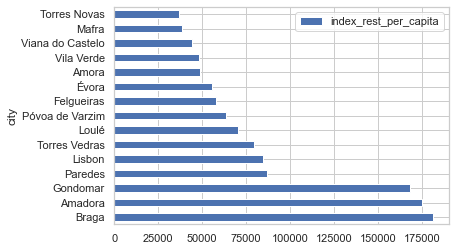

In [67]:
from matplotlib import pyplot as plt

index_rests_filter = index_rests.head(15)

plt.figure(figsize=(50,8))
ax = index_rests_filter.plot.barh(x='city', y='index_rest_per_capita', rot=0)
